**Mount Google Drive:**

Accesses training and testing datasets stored on Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import os
import zipfile
import shutil
from torchvision import datasets, transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn as nn

**Unzip Datasets:**

Extracts the training and testing image datasets.

In [3]:
from genericpath import exists
#Paths to zip file
training_zip_file_path = '/content/drive/MyDrive/training_set.zip'
testing_zip_file_path = '/content/drive/MyDrive/test_set.zip'

#Create folder where zip file can be extracted
# os.makedirs('/content/training_data')
# os.makedirs('/content/test_data')

#Unzip training data
with zipfile.ZipFile(training_zip_file_path, 'r') as zip_ref:
  zip_ref.extractall('/content/training_data')

#Unzip test data
with zipfile.ZipFile(testing_zip_file_path, 'r') as zip_ref:
  zip_ref.extractall('/content/test_data')



# ------------------ Move and clean test_data ------------------
nested_folder_path_test = os.path.join('/content/test_data', 'test_set', 'test_set')

for folder_name in ["cats", "dogs"]:
    src_folder = os.path.join(nested_folder_path_test, folder_name)
    dest_folder = os.path.join('/content/test_data', folder_name)
    shutil.move(src_folder, dest_folder)

# Now remove the extra nested folders
shutil.rmtree(os.path.join('/content/test_data', 'test_set'))

# ------------------ Move and clean training_data ------------------
nested_folder_path_train = os.path.join('/content/training_data', 'training_set', 'training_set')

for folder_name in ["cats", "dogs"]:
    src_folder = os.path.join(nested_folder_path_train, folder_name)
    dest_folder = os.path.join('/content/training_data', folder_name)
    shutil.move(src_folder, dest_folder)

# Remove the extra nested folders
shutil.rmtree(os.path.join('/content/training_data', 'training_set'))

**Set up Device:**

Checks for GPU availability and sets the device for training.

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


**Data Pre-processing**

Resize and transform images. Create data augmentation for better generalization.

In [5]:
#Transform image data

image_width = 224
image_height = 224
image_size = (image_width, image_height)

train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])


#Create training set
train_data_augmented = datasets.ImageFolder(root='/content/training_data', transform=train_transform,target_transform=None)


#Create test set
test_data_augmented = datasets.ImageFolder(root='/content/test_data', transform=test_transform)

class_names = train_data_augmented.classes
print("Class Names:",class_names)

NUM_WORKERS = os.cpu_count()
print("Number of workers:",NUM_WORKERS)

BATCH_SIZE = 32
torch.manual_seed(42)

#Turn train and test datasets into dataloaders
train_dataloader_augmented = DataLoader(
    train_data_augmented,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS
)
print(f"Train loader length: {len(train_dataloader_augmented)}")

test_dataloader_augmented = DataLoader(
    test_data_augmented,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS
)

Class Names: ['cats', 'dogs']
Number of workers: 2
Train loader length: 251


# **CNN Classifier**
Implements a custom CNN architecture for image classification.

In [6]:
class CNNClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.conv_layer_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )
        self.conv_layer_5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*7*7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.conv_layer_5(x)
        x = self.classifier(x)
        return x

model = CNNClassifier().to(device)

**Model Summary:**

Displays a summary of the model's layers and parameters.

In [7]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
              ReLU-6         [-1, 64, 112, 112]               0
       BatchNorm2d-7         [-1, 64, 112, 112]             128
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
             ReLU-10          [-1, 128, 56, 56]               0
      BatchNorm2d-11          [-1, 128, 56, 56]             256
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         295,168
             ReLU-14          [-1, 256,

In [8]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):
  model.train()
  train_loss, train_acc = 0,0

  for (X,y) in dataloader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [9]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [10]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    results = {"train_loss": [],"train_acc": [],"test_loss": [],"test_acc": []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 35
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
from timeit import default_timer as timer
start_time = timer()
model_results = train(model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9621 | train_acc: 0.5345 | test_loss: 0.6702 | test_acc: 0.5657
Epoch: 2 | train_loss: 0.6830 | train_acc: 0.5679 | test_loss: 0.6318 | test_acc: 0.6281
Epoch: 3 | train_loss: 0.6690 | train_acc: 0.5747 | test_loss: 0.6942 | test_acc: 0.6034
Epoch: 4 | train_loss: 0.6601 | train_acc: 0.5975 | test_loss: 0.6248 | test_acc: 0.6630
Epoch: 5 | train_loss: 0.6487 | train_acc: 0.6245 | test_loss: 0.6040 | test_acc: 0.6554
Epoch: 6 | train_loss: 0.6327 | train_acc: 0.6402 | test_loss: 0.5682 | test_acc: 0.7008
Epoch: 7 | train_loss: 0.6182 | train_acc: 0.6545 | test_loss: 0.6412 | test_acc: 0.5813
Epoch: 8 | train_loss: 0.6095 | train_acc: 0.6701 | test_loss: 0.5129 | test_acc: 0.7450
Epoch: 9 | train_loss: 0.5787 | train_acc: 0.6969 | test_loss: 0.5274 | test_acc: 0.7469
Epoch: 10 | train_loss: 0.5641 | train_acc: 0.7099 | test_loss: 0.5211 | test_acc: 0.7711
Epoch: 11 | train_loss: 0.5607 | train_acc: 0.7165 | test_loss: 0.4564 | test_acc: 0.7892
Epoch: 12 | train_l

In [12]:
torch.save(model.state_dict(), "/content/drive/MyDrive/binary_classifier.pth")

**Plot Loss Curves:**

Visualizes the training and testing loss and accuracy over epochs.

In [13]:
import matplotlib.pyplot as plt
def plot_loss_curves(results):

    results = dict(list(model_results.items()))
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

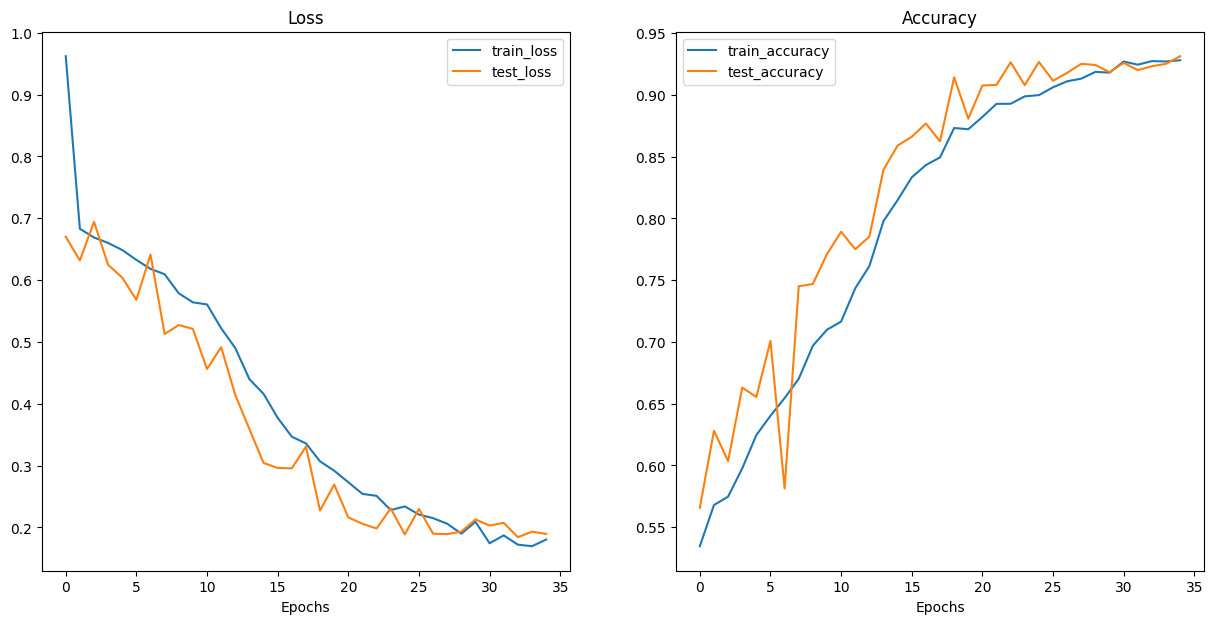

In [14]:
plot_loss_curves(model_results)

**Evaluate the Model**

Predicts the class of a custom image and displays the result.

tensor([[3.1648e-04, 9.9968e-01]], device='cuda:0')


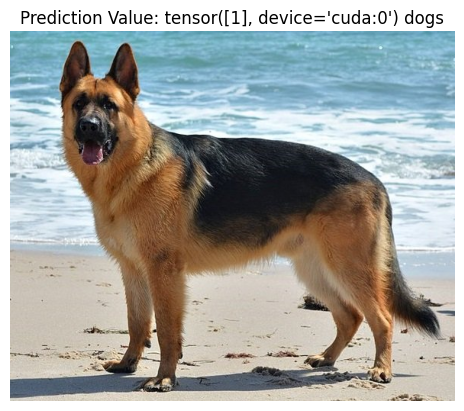

In [15]:
# Choose a image.
custom_image_path = "/content/drive/MyDrive/1_dog.jpeg"

import torchvision
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image = custom_image / 255
custom_image_transform = transforms.Compose([
    transforms.Resize(image_size),
])

custom_image_transformed = custom_image_transform(custom_image)


model.eval()
with torch.inference_mode():
    # custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(custom_image_pred_probs)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]


# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Prediction Value: {custom_image_pred_label} {custom_image_pred_class}")
plt.axis(False);